In [4]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [5]:
import sys
import pandas as pd
sys.path.append('../../param_search')
import param_search as ps

## Setup experiment

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [21]:
# define a job template and name format
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=bio170034p
#SBATCH --partition=BatComputer
#SBATCH --gres=gpu:rtx6000:1
#SBATCH -x v034
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project
nvidia-smi

python ../../../train.py \\
    --data_name phantom \\
    --data_root ../../../data/phantom_lung3_{bias_range}_{dummy_targets:d} \\
    --mesh_version {mesh_version} \\
    --test_pid {test_pid} \\
    --input_anat {input_anat} \\
    --input_coords {input_coords} \\
    --model_arch {model_arch} \\
    --output_func {output_func} \\
    --trainer_task {trainer_task} \\
    --rho_value 0 \\
    --learning_rate {lr:.0e} \\
    --num_epochs {num_epochs} \\
    --test_every {test_every} \\
    --save_every {save_every} \\
    --save_prefix {job_name} \\

echo Done
'''

In [379]:
param_space = ps.ParamSpace(
    data_name='phantom',
    anat_range=[250],
    dummy_targets=[False, True],
    conv_channels=[8, 16, 32],
    output_func=['relu', 'exp'],
)

param_space = ps.ParamSpace(
    data_name='phantom',
    anat_range=[250, 125, 0],
    dummy_targets=[False, True],
    conv_channels=[32],
    output_func=['relu'],
    random_seed=[]
)

param_space = ps.ParamSpace(
    bias_range=[250, 125, 0],
    dummy_targets=[False, True],
    conv_channels=[32],
    output_func=['relu'],
    random_seed=[1, 2, 3],
)
name_format = 'train__phantom__{bias_range}__{dummy_targets:d}__{conv_channels}__{output_func}__{random_seed}'

param_space = ps.ParamSpace(
    mesh_version=[10],
    bias_range=[0],
    dummy_targets=[False],
    test_pid=range(10),
    trainer_task=['fit'],
    model_arch=['param_map'],
    output_func=['softplus', 'exp'], # relu
    lr=[1e-5, 1e-4, 1e-3],
    num_epochs=1000,
    test_every=100,
    save_every=100,
)
#name_format = 'fit__phantom__{bias_range}__{dummy_targets:d}__{test_pid}__{output_func}'
name_format = 'fit__phantom__{output_func}__{lr:.0e}__{test_pid}'

param_space = ps.ParamSpace(
    mesh_version=[10],
    bias_range=[0],
    dummy_targets=[False],
    test_pid=range(10),
    trainer_task=['fit'],
    model_arch=['unet3d'],
    input_anat=[False],
    input_coords=[True],
    output_func=['relu', 'softplus', 'exp'],
    lr=[1e-5],
    num_epochs=1000,
    test_every=100,
    save_every=100,
)
name_format = 'fit__phantom__{output_func}__{lr:.0e}__{test_pid}'

param_space = ps.ParamSpace(
    mesh_version=[10],
    bias_range=[250, 125, 0],
    dummy_targets=[False, True],
    test_pid=None,
    trainer_task=['train'],
    model_arch=['unet3d'],
    input_anat=[True],
    input_coords=[False, True],
    output_func=['softplus'],
    lr=[1e-5],
    num_epochs=200,
    test_every=10,
    save_every=10,
)
name_format = 'train__phantom__{bias_range}__{dummy_targets:d}__{input_anat:d}{input_coords:d}'

for p in param_space:
    print(name_format.format(**p))

print(len(param_space))

train__phantom__250__0__10
train__phantom__250__0__11
train__phantom__250__1__10
train__phantom__250__1__11
train__phantom__125__0__10
train__phantom__125__0__11
train__phantom__125__1__10
train__phantom__125__1__11
train__phantom__0__0__10
train__phantom__0__0__11
train__phantom__0__1__10
train__phantom__0__1__11
12


## Submit jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [380]:
expt_names = [
    '2024-11-22__phantom__250',
    '2024-11-22__phantom__250__resub',
    '2024-11-30__phantom__relu',
    '2024-11-30__phantom__relu__resub',
    '2024-12-02__phantom__seed',
    '2024-12-09__phantom__fit',
    '2024-12-10__phantom__fit',
    '2024-12-10__phantom__rtx5000',
    '2024-12-11__phantom__fit__relu',
    '2024-12-11__phantom__fit__exps',
    '2024-12-12__phantom__fit__coords', # ran with input_anat AND input_coords
    '2024-12-12__phantom__fit__coords2', # only has input_coords
    '2024-12-12__phantom__train__coords'
]
expt_name = expt_names[-1]
expt_name

'2024-12-12__phantom__train__coords'

In [381]:
do_submit = True
if do_submit:
    jobs = ps.submit(template, name_format, param_space, work_dir=expt_name)
    jobs.to_csv(f'{expt_name}.jobs')

100%|██████████| 12/12 [00:00<00:00, 58.22it/s]


/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/job_queues.py:235: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('', float('nan')).map(pd.to_numeric)


## Monitor jobs

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [72]:
#expt_name = '2024-12-02__phantom__seed'
jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)
status = ps.status(jobs, parse_stderr=True)
status

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/job_queues.py:235: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace('', float('nan')).map(pd.to_numeric)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/__init__.py:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING'
 'PENDING' 'PENDING' 'PENDING' 'PENDING' 'PENDING']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  status.update(new_status)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/__init__.

,index,mesh_version,bias_range,dummy_targets,test_pid,trainer_task,model_arch,input_anat,input_coords,output_func,...,save_every,job_name,partition,job_state,node_id,runtime,work_dir,array_idx,stdout,stderr
job_id,,,,,,,,,,,,,,,,,,,,,
27632832,0,10,250,False,NaN,train,unet3d,True,False,softplus,...,10,train__phantom__250__0__10,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632833,1,10,250,False,NaN,train,unet3d,True,True,softplus,...,10,train__phantom__250__0__11,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632834,2,10,250,True,NaN,train,unet3d,True,False,softplus,...,10,train__phantom__250__1__10,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632835,3,10,250,True,NaN,train,unet3d,True,True,softplus,...,10,train__phantom__250__1__11,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632836,4,10,125,False,NaN,train,unet3d,True,False,softplus,...,10,train__phantom__125__0__10,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632837,5,10,125,False,NaN,train,unet3d,True,True,softplus,...,10,train__phantom__125__0__11,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632838,6,10,125,True,NaN,train,unet3d,True,False,softplus,...,10,train__phantom__125__1__10,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632839,7,10,125,True,NaN,train,unet3d,True,True,softplus,...,10,train__phantom__125__1__11,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN
27632840,8,10,0,False,NaN,train,unet3d,True,False,softplus,...,10,train__phantom__0__0__10,BatComputer,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/lung-proje...,NaN,NaN,NaN


In [70]:
status['job_state'] = status['job_state'].fillna('DONE')
status['stderr'] = status['stderr'].fillna('N/A')
status.groupby(['job_state', 'stderr'])[['job_name']].count()

,,job_name
job_state,stderr,
DONE,SyntaxError: invalid syntax,7
RUNNING,SyntaxError: invalid syntax,5


In [14]:
status.iloc[0].stderr

'SyntaxError: invalid syntax'

## Analyze results

[[Setup](#Setup-experiment)] [[Submit](#Submit-jobs)] [[Monitor](#Monitor-jobs)] [[Analyze](#Analyze-results)]

In [116]:
expt_name1 = '2024-12-02__phantom__seed'
jobs1 = pd.read_csv(f'{expt_name1}.jobs', index_col=0)
m = ps.metrics(jobs1, sep=',')
m

,bias_range,dummy_targets,conv_channels,output_func,random_seed,job_name,job_id,partition,job_state,node_id,...,e_850_corr,true_950_corr,true_900_corr,true_850_corr,e_dis0_corr,e_dis1_corr,e_dis2_corr,true_dis0_corr,true_dis1_corr,true_dis2_corr
0,250,False,32,relu,1,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,0.313085,-0.041194,-0.134418,-0.203602,NaN,NaN,NaN,NaN,NaN,NaN
1,250,False,32,relu,1,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,0.259523,-0.017306,-0.050227,-0.081975,NaN,NaN,NaN,NaN,NaN,NaN
2,250,False,32,relu,1,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,0.047907,NaN,NaN,-0.033242,NaN,NaN,NaN,NaN,NaN,NaN
3,250,False,32,relu,1,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,250,False,32,relu,1,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331231,0,True,32,relu,3,train__phantom__0__1__32__relu__3,27268635,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331232,0,True,32,relu,3,train__phantom__0__1__32__relu__3,27268635,BatComputer,PENDING,(None),...,0.004782,NaN,-0.009477,-0.038171,NaN,NaN,NaN,NaN,NaN,NaN
331233,0,True,32,relu,3,train__phantom__0__1__32__relu__3,27268635,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
331234,0,True,32,relu,3,train__phantom__0__1__32__relu__3,27268635,BatComputer,PENDING,(None),...,-0.065124,NaN,NaN,-0.193874,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


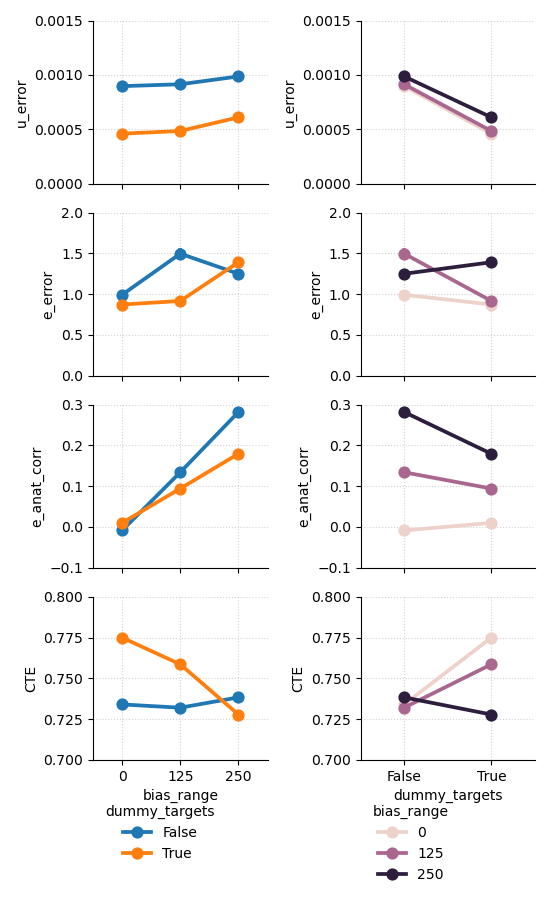

In [117]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch > 100) & (m.rep == 'dofs')],
    x=['bias_range', 'dummy_targets'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75,
    ylim=dict(u_error=[0, 0.0015], e_error=[0, 2], e_anat_corr=[-0.1, 0.3], CTE=[0.7, 0.8])
)

<IPython.core.display.Javascript object>


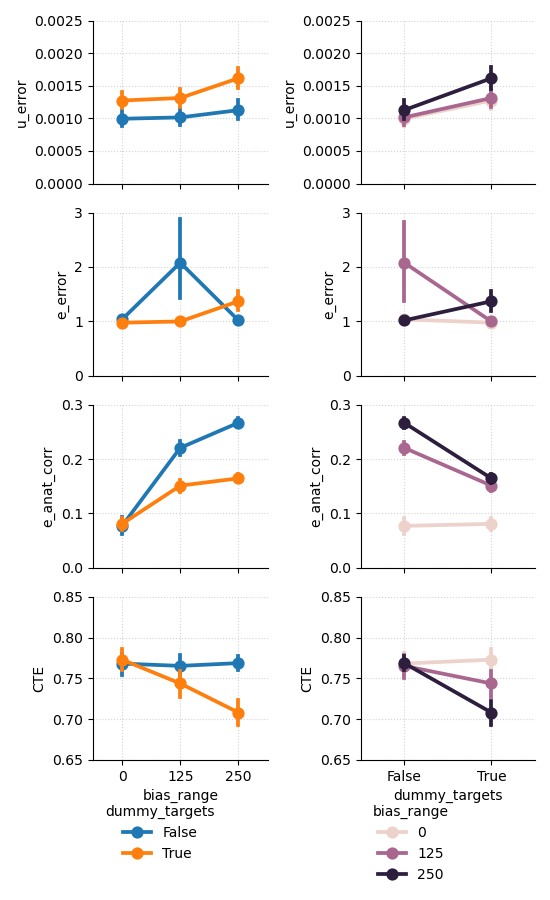

In [57]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'dofs')],
    x=['bias_range', 'dummy_targets'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75,
    ylim=dict(u_error=[0, 0.0025], e_error=[0, 3], e_anat_corr=[-0.0, 0.3], CTE=[0.65, 0.85])
)

<IPython.core.display.Javascript object>


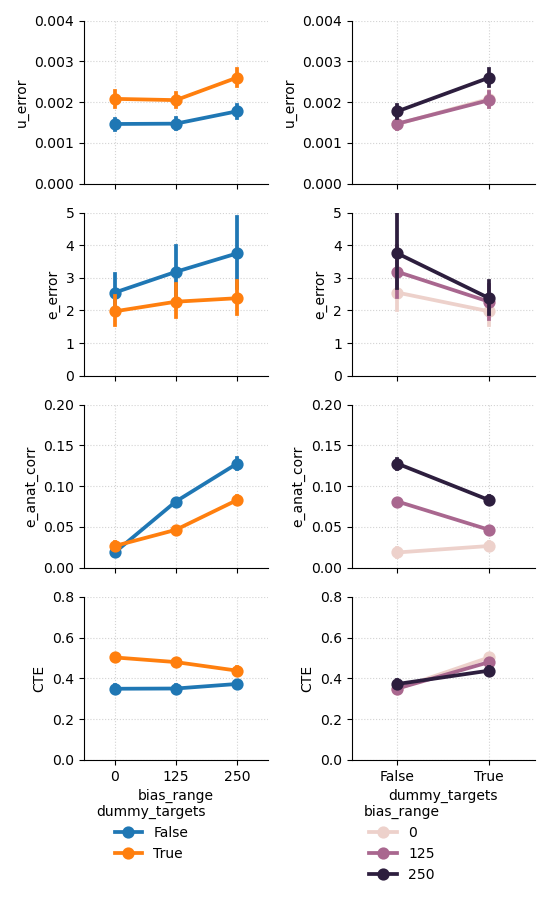

In [58]:
%autoreload
fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'image')],
    x=['bias_range', 'dummy_targets'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    height=2.25, width=2.75,
    ylim=dict(u_error=[0, 0.004], e_error=[0, 5], e_anat_corr=[-0.0, 0.2], CTE=[0, 0.8])
)

<IPython.core.display.Javascript object>


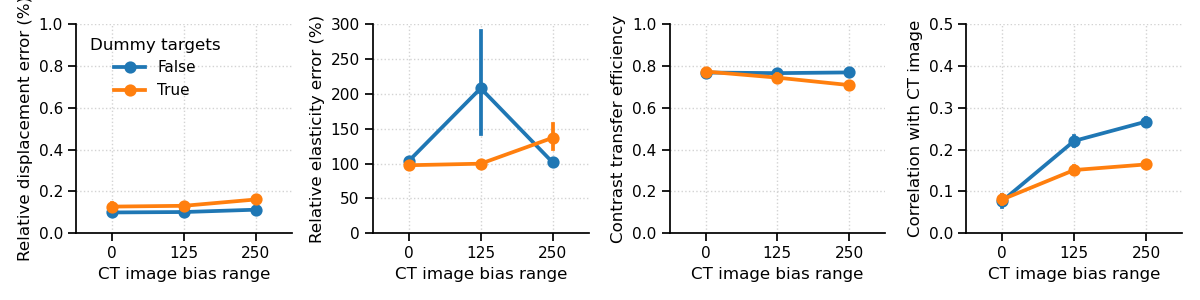

In [59]:
%autoreload

import seaborn as sns
sns.set_context('notebook')

u_error_col = 'Relative displacement error (%)'
e_error_col = 'Relative elasticity error (%)'
cte_col     = 'Contrast transfer efficiency'
e_anat_corr_col = 'Correlation with CT image'
bias_range_col = 'CT image bias range'
dummy_target_col = 'Dummy targets'

m[u_error_col] = m['u_error'] * 100
m[e_error_col] = m['e_error'] * 100
m[cte_col] = m['CTE'] * 1
m[e_anat_corr_col] = m['e_anat_corr'] * 1
m[bias_range_col] = m['bias_range'] * 1
m[dummy_target_col] = m['dummy_targets'].astype(bool)

fig = ps.plot(
    m[(m.phase == 'test') & (m.epoch > 100) & (m.rep == 'dofs')],
    x=[bias_range_col],
    y=[u_error_col, e_error_col, cte_col, e_anat_corr_col],
    hue=dummy_target_col,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, 1), loc='upper left', title=dummy_target_col),
    legend_col=0,
    tight=True,
    height=3,
    width=3,
    ylim={
        u_error_col: [0, 1],
        e_error_col: [0, 300],
        e_anat_corr_col: [0, 0.5],
        cte_col: [0.0, 1.0]
    },
    n_cols=4,
)
for ext in ['png', 'pdf']:
    fig.savefig(f'phantom_lung_results.{ext}', bbox_inches='tight', dpi=400)

<IPython.core.display.Javascript object>


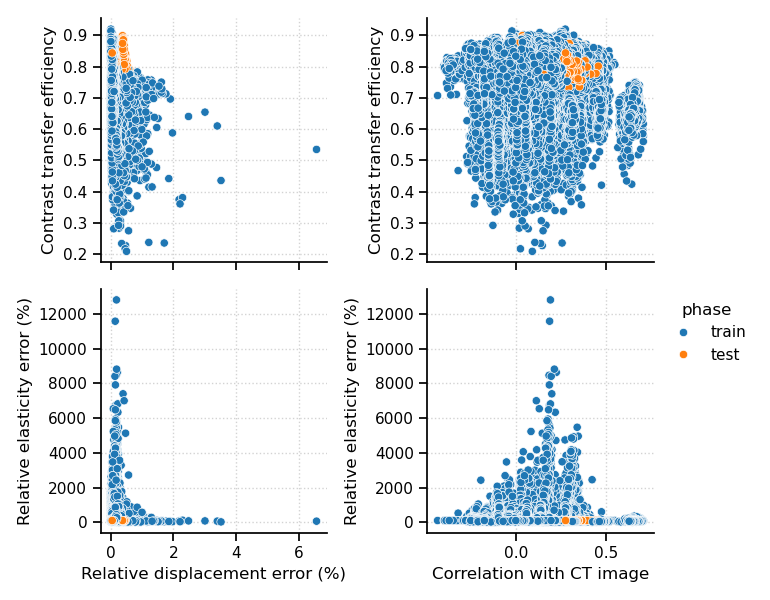

In [60]:
fig = ps.plot(
    m[(m.epoch > 100) & (m.rep == 'dofs') & (m.example != 'phantom4')],
    x=[u_error_col, e_anat_corr_col],
    y=[cte_col, e_error_col],
    hue='phase',
    legend_col=1,
    legend_kws=dict(bbox_to_anchor=(1, 1), loc='upper left'),
    legend=True,
    tight=True,
    height=3,
    width=3.85,
    plot_func=sns.scatterplot
)

# Baseline

In [118]:
expt_name2 = '2024-12-11__phantom__fit__relu'
jobs2 = pd.read_csv(f'{expt_name2}.jobs', index_col=0)
m2 = ps.metrics(jobs2, sep=',')
m2

,mesh_version,trainer_task,model_arch,output_func,bias_range,dummy_targets,test_pid,lr,num_epochs,test_every,...,e_850_corr,true_950_corr,true_900_corr,true_850_corr,e_dis0_corr,e_dis1_corr,e_dis2_corr,true_dis0_corr,true_dis1_corr,true_dis2_corr
0,10,fit,param_map,relu,0,False,0,0.00001,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10,fit,param_map,relu,0,False,0,0.00001,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10,fit,param_map,relu,0,False,0,0.00001,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10,fit,param_map,relu,0,False,0,0.00001,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,fit,param_map,relu,0,False,0,0.00001,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30191,10,fit,param_map,relu,0,False,9,0.00100,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30192,10,fit,param_map,relu,0,False,9,0.00100,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30193,10,fit,param_map,relu,0,False,9,0.00100,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30194,10,fit,param_map,relu,0,False,9,0.00100,1000,100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


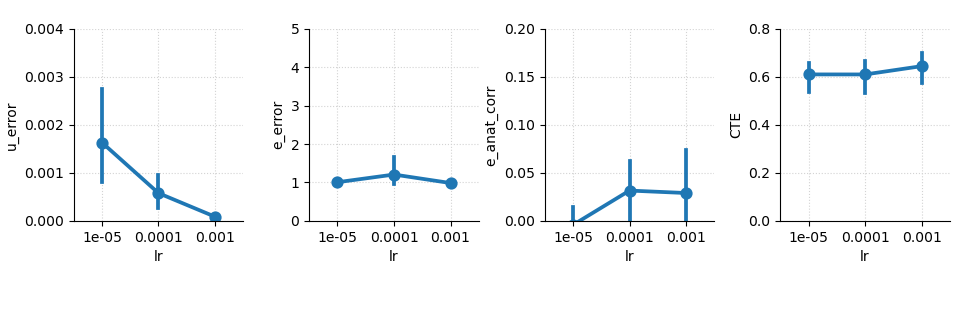

In [126]:
m = m2

fig = ps.plot(
    m[(m.phase == 'train') & (m.epoch == 1000) & (m.rep == 'dofs')],
    x=['lr'],
    y=['u_error', 'e_error', 'e_anat_corr', 'CTE'],
    hue=None,
    legend=True,
    legend_kws=dict(bbox_to_anchor=(0, -0.2)),
    tight=True,
    n_cols = 4,
    height=2.25, width=2.75,
    ylim=dict(u_error=[0, 0.004], e_error=[0, 5], e_anat_corr=[-0.0, 0.2], CTE=[0, 0.8])
)

# Image grids

In [30]:
import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

sys.path.append('..')
import project

In [128]:
param_space = ps.ParamSpace(
    bias_range=[250, 125, 0],
    dummy_targets=[False, True],
    conv_channels=[32],
    output_func=['relu'],
    random_seed=[1, 2, 3],
)
name_format = 'train__phantom__{bias_range}__{dummy_targets:d}__{conv_channels}__{output_func}__{random_seed}'

expt_name = '2024-12-02__phantom__seed'
expt_name

'2024-12-02__phantom__seed'

In [26]:
import numpy as np
import torch

n_models = len(param_space) // 3
n_samples = 10

masks = [[] for i in range(n_models)]
a_images = [[] for i in range(n_models)]
e_preds = [[] for i in range(n_models)]
e_trues = [[] for i in range(n_models)]

for i in range(n_models):
    job_params = param_space[i*3]
    job_name = name_format.format(**job_params)
    epoch = 200
    
    model = project.model.UNet3D(
        in_channels=1,
        out_channels=1,
        num_levels=3,
        num_conv_layers=2,
        conv_channels=job_params['conv_channels'],
        conv_kernel_size=3,
        output_func=job_params['output_func']
    ).cuda()
    
    model_path = f'{expt_name}/{job_name}/state/model_{epoch}.pt'
    print(model_path)
    model.load_state_dict(torch.load(model_path))
    
    bias_range = job_params['bias_range']
    dummy_targets = job_params['dummy_targets']
    data_root = f'../data/phantom_lung3_{bias_range}_{dummy_targets:d}'
    
    for j in range(n_samples):
        phantom = project.phantom.Phantom(data_root, phantom_id=j)
        anat_file = phantom.anat_file()
        mask_file = phantom.mask_file()
        elast_file = phantom.elast_file()
    
        mask = project.data.load_nii_file(mask_file).get_fdata()
        a_image = project.data.load_nii_file(anat_file).get_fdata()
        e_true = project.data.load_nii_file(elast_file).get_fdata()

        a_t = torch.as_tensor(a_image, dtype=torch.float32, device='cuda')
        e_t = (model.forward(a_t[None,None,...])[0,0]*1000).clamp(min=1, max=1e12)
        e_pred = e_t.detach().cpu().numpy() * (mask > 0)
        
        masks[i].append(mask)
        a_images[i].append(a_image)
        e_preds[i].append(e_pred)
        e_trues[i].append(e_true)
        
    del model

/var/tmp/ipykernel_21357/1661750482.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


2024-12-02__phantom__seed/train__phantom__250__0__32__relu__1/state/model_200.pt
Loading ../data/phantom_lung3_250_0/phantom0/phantom0_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom0/phantom0_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom0/phantom0_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom1/phantom1_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom1/phantom1_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom1/phantom1_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom2/phantom2_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom2/phantom2_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom2/phantom2_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom3/phantom3_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_250_0/phantom3/phantom3_anat.nii.gz... (256, 2

Loading ../data/phantom_lung3_125_1/phantom1/phantom1_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom2/phantom2_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom2/phantom2_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom2/phantom2_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom3/phantom3_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom3/phantom3_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom3/phantom3_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom4/phantom4_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom4/phantom4_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom4/phantom4_elast.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom5/phantom5_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_125_1/phantom5/phantom5_anat.nii.gz... (25

In [54]:
x_shape, y_shape, z_shape = (256, 256, 94)
x_res, y_res, z_res = (0.97, 0.97, 2.5)

x_extent = (x_shape - 1) * x_res
y_extent = (y_shape - 1) * y_res
z_extent = (z_shape - 1) * z_res

y_slice = y_shape//2

ax_height = 1.5
ax_width = ax_height * x_extent/z_extent
print((ax_height, ax_width))

e_cmap = project.visual.mre_color_map()

vmaxs = []
for i in range(n_models):
    all_e = np.stack(e_preds[i])
    all_e[all_e == 0] = np.nan
    vmax = np.nanpercentile(all_e, 75) * 4
    vmaxs.append(vmax)

(1.5, 1.5958064516129031)


In [29]:
for p in param_space:
    print(p)

Params([('bias_range', 250), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 250), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 2)])
Params([('bias_range', 250), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 3)])
Params([('bias_range', 250), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 250), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 2)])
Params([('bias_range', 250), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 3)])
Params([('bias_range', 125), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 125), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 2)])
Params([('b

In [33]:
model_idx = 4
print(param_space[model_idx * 3])

Params([('bias_range', 0), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])


<IPython.core.display.Javascript object>


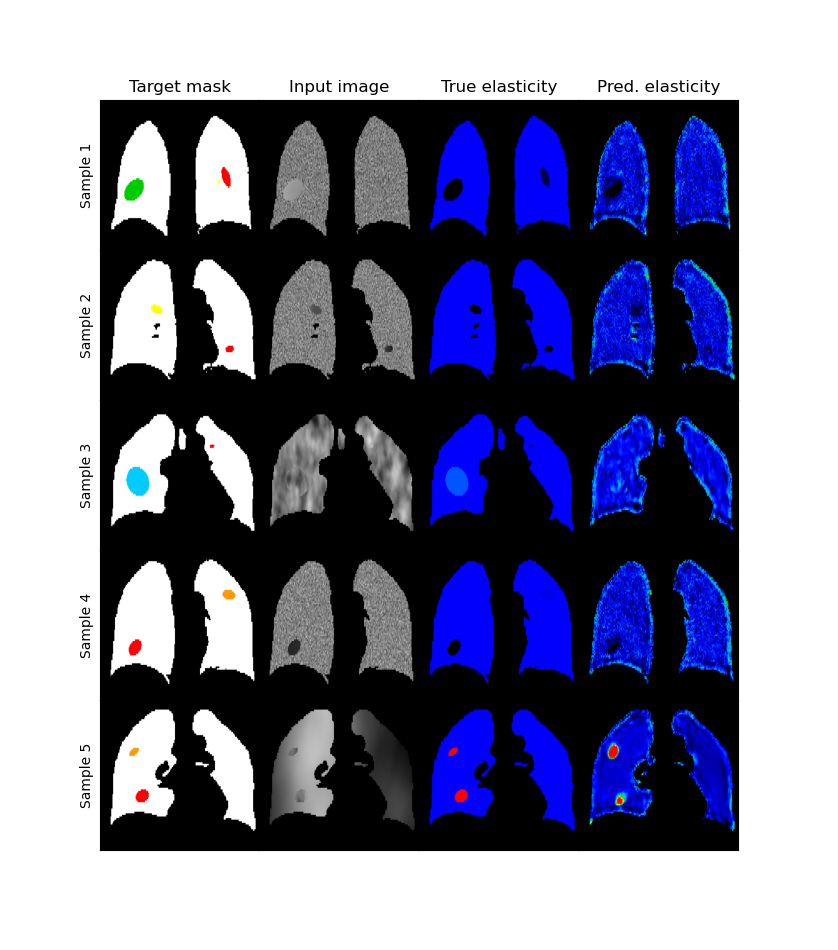

In [36]:
%autoreload

def get_y_slice(mask):
    density = mask.sum(axis=(0,2)) / mask.sum()
    return np.abs(density.cumsum() - 0.5).argmin()

columns = ['mask', 'anat', 'e_true', 'e_pred']
samples = range(5)

n_rows = len(samples)
n_cols = len(columns)

fig, axes, cbar_ax = project.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=1)

for row_idx, sample_idx in enumerate(samples):
    
    mask = masks[model_idx][sample_idx]
    a_image = a_images[model_idx][sample_idx]
    e_true = e_trues[model_idx][sample_idx]
    e_pred = e_preds[model_idx][sample_idx]
    vmax = vmaxs[model_idx]
    
    bg_mask = (mask == 1)
    e_pred_0 = (e_pred * bg_mask).sum() / bg_mask.sum()
    e_true_0 = (e_true * bg_mask).sum() / bg_mask.sum()
    
    e_pred = e_pred / e_pred_0
    e_true = e_true / e_true_0
    vmax = 6
    
    y_slice = get_y_slice((mask > 1)**2)
    
    for col_idx, column in enumerate(columns):
        ax = axes[row_idx,col_idx]

        if col_idx == 0:
            ax.set_ylabel(f'Sample {sample_idx+1}')
            
        if column == 'anat':
            if row_idx == 0:
                ax.set_title('Input image')
            project.visual.imshow(
                ax, (a_image)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('CT')
            )
        
        elif column == 'mask':
            if row_idx == 0:
                ax.set_title('Target mask')
            project.visual.imshow(
                ax, mask[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('regions')
            )
            masks.append(mask)
            
        elif column == 'e_true':
            if row_idx == 0:
                ax.set_title('True elasticity')
            project.visual.imshow(
                ax, (e_true)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                cmap=e_cmap, vmax=vmax, vmin=-vmax
            )
            
        elif column == 'e_pred':
            if row_idx == 0:
                ax.set_title('Pred. elasticity')
            project.visual.imshow(
                ax, (e_pred)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                cmap=e_cmap, vmax=vmax, vmin=-vmax
            )

        ax.set_xticks([])
        ax.set_yticks([])

for ext in ['png', 'pdf']:
    fig.savefig(f'phantom_images.{ext}', bbox_inches='tight', dpi=400)

In [44]:
for p in param_space:
    if p['random_seed'] == 1:
        print(p)

Params([('bias_range', 250), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 250), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 125), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 125), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 0), ('dummy_targets', False), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])
Params([('bias_range', 0), ('dummy_targets', True), ('conv_channels', 32), ('output_func', 'relu'), ('random_seed', 1)])


<IPython.core.display.Javascript object>


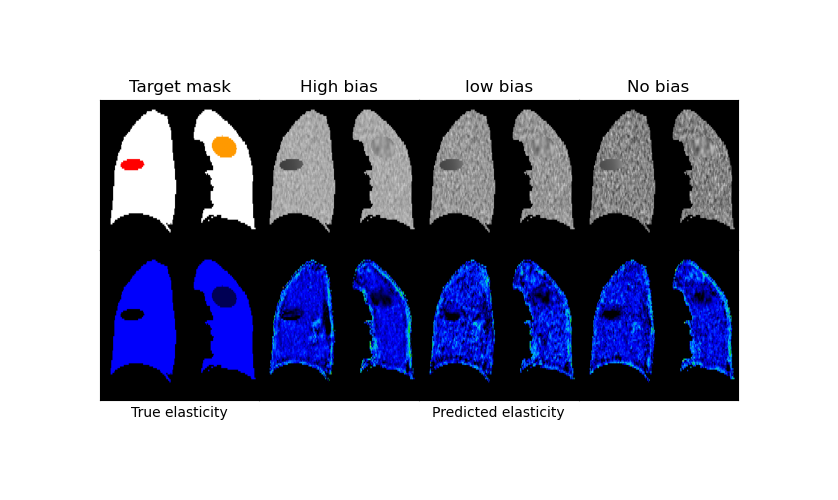

<IPython.core.display.Javascript object>


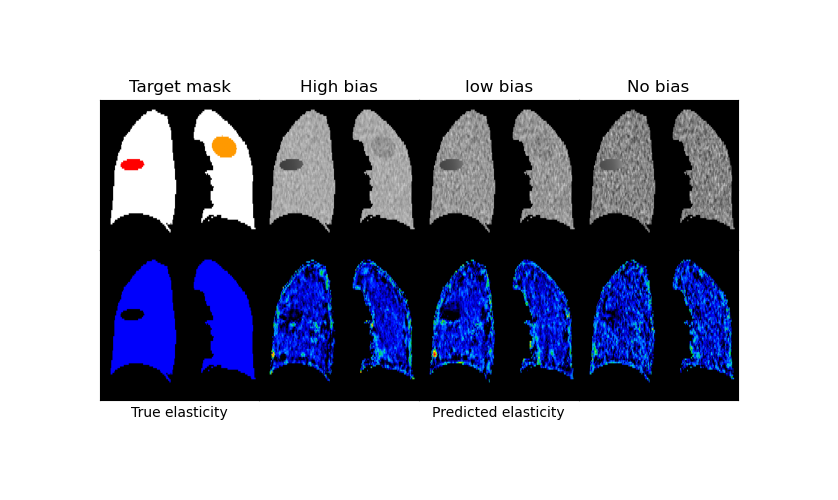

In [86]:
def plot_bias_range(plot_name, model_inds, sample_idx):

    n_rows = 2 # anatomic images vs predicted elasticity
    n_cols = 4 # bias range values

    fig, axes, cbar_ax = project.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=1)

    for row_idx in range(n_rows):

        mask = masks[model_inds[0]][sample_idx]
        e_true = e_trues[model_inds[0]][sample_idx]

        bg_mask = (mask == 1)
        e_true_0 = (e_true * bg_mask).sum() / bg_mask.sum()
        e_true = e_true / e_true_0    
        vmax = 6

        interest = (mask > 1) # * np.log10(e_true + 1e-6)
        y_slice = get_y_slice(interest**2)

        for col_idx, column in enumerate(columns):
            ax = axes[row_idx,col_idx]

            if row_idx == 0:
                if col_idx == 0:
                    ax.set_title('Target mask')
                    project.visual.imshow(
                        ax, mask[:,y_slice,:],
                        aspect=z_res/x_res,
                        interpolation_stage='rgba',
                        **project.visual.get_color_map('regions')
                    )
                else:
                    ax.set_title(['High bias', 'low bias', 'No bias'][col_idx - 1])
                    model_idx = model_inds[col_idx - 1]
                    a_image = a_images[model_idx][sample_idx]
                    project.visual.imshow(
                        ax, a_image[:,y_slice,:],
                        aspect=z_res/x_res,
                        interpolation_stage='rgba',
                        **project.visual.get_color_map('CT')
                    )

            elif row_idx == 1:
                if col_idx == 0:
                    ax.set_xlabel('True elasticity')
                    project.visual.imshow(
                        ax, e_true[:,y_slice,:],
                        aspect=z_res/x_res,
                        interpolation_stage='rgba',
                        cmap=e_cmap, vmax=vmax, vmin=-vmax
                    )
                else:
                    ax.set_xlabel(['', 'Predicted elasticity', ''][col_idx - 1])
                    model_idx = model_inds[col_idx - 1]
                    e_pred = e_preds[model_idx][sample_idx]
                    e_pred_0 = (e_pred * bg_mask).sum() / bg_mask.sum()
                    e_pred = e_pred / e_pred_0
                    project.visual.imshow(
                        ax, e_pred[:,y_slice,:],
                        aspect=z_res/x_res,
                        interpolation_stage='rgba',
                        cmap=e_cmap, vmax=vmax, vmin=-vmax
                    )            

            ax.set_xticks([])
            ax.set_yticks([])
            
    for ext in ['png', 'pdf']:
        fig.savefig(f'{plot_name}.{ext}', bbox_inches='tight', dpi=400)


no_dummy_inds = [0, 2, 4]
yes_dummy_inds = [1, 3, 5]
sample_idx = 5
      
plot_bias_range('no_dummy_images', no_dummy_inds, sample_idx)
plot_bias_range('yes_dummy_images', yes_dummy_inds, sample_idx)

In [117]:
param_space = ps.ParamSpace(
    mesh_verson=[10],
    bias_range=[0],
    dummy_targets=[False],
    model_arch=['unet3d'],
    conv_channels=[32],
    random_seed=[1],
    lr=[1e-5],
) * (
    ps.ParamSpace(
        trainer_task=['train'],
        input_anat=[True],
        input_coords=[False],
        output_func=['relu'],
        num_epochs=200,
    ) + ps.ParamSpace(
        trainer_task=['fit'],
        input_anat=[True, False],
        input_coords=[True],
        output_func=['exp'],
        num_epochs=1000
    )
)
name_formats = [
    'train__phantom__{bias_range}__{dummy_targets:d}__{conv_channels}__{output_func}__{random_seed}',
    'fit__phantom__{output_func}__{lr:.0e}__{test_pid}',
    'fit__phantom__{output_func}__{lr:.0e}__{test_pid}',
]
expt_names = [
    '2024-12-02__phantom__seed',
    '2024-12-12__phantom__fit__coords',
    '2024-12-12__phantom__fit__coords2',
]
len(param_space)

3

In [118]:
%autoreload
import numpy as np
import torch

n_models = 3
n_samples = 10 # test pid

masks = [[] for i in range(n_models)]
a_images = [[] for i in range(n_models)]
e_preds = [[] for i in range(n_models)]
e_trues = [[] for i in range(n_models)]

for i in range(n_models):
    for j in range(n_samples):
        job_params = param_space[i]
        job_params['test_pid'] = j
        job_name = name_formats[i].format(**job_params)
        expt_name = expt_names[i]
        print(job_name)

        data_root = f'../data/phantom_lung3_{bias_range}_{dummy_targets:d}'
        phantom = project.phantom.Phantom(data_root, phantom_id=j)
        anat_file = phantom.anat_file()
        mask_file = phantom.mask_file()
        elast_file = phantom.elast_file()
        
        mask_nifti = project.data.load_nii_file(mask_file)
        mask = mask_nifti.get_fdata()
        resolution = mask_nifti.header.get_zooms()
        a_image = project.data.load_nii_file(anat_file).get_fdata()
        e_true = project.data.load_nii_file(elast_file).get_fdata()
        print(mask.shape, a_image.shape, e_true.shape)
        
        shape = e_true.shape
        if job_params['model_arch'] == 'unet3d':
            model = project.model.UNet3D(
                in_channels=1*job_params['input_anat'] + 3*job_params['input_coords'],
                out_channels=1,
                num_levels=3,
                num_conv_layers=2,
                conv_channels=job_params['conv_channels'],
                conv_kernel_size=3,
                output_func=job_params['output_func']
            ).cuda()
            
        elif job_params['model_arch'] == 'param_map':
            model = project.model.ParameterMap(
                shape=(1, shape[0]//2, shape[1]//2, shape[2]//2),
                upsample_mode='nearest',
                conv_kernel_size=3,
                output_func=job_params['output_func']
            ).cuda()
        
        epoch = job_params['num_epochs']
        model_path = f'{expt_name}/{job_name}/state/model_{epoch}.pt'
        model.load_state_dict(torch.load(model_path))
        
        binary_mask = torch.as_tensor(mask > 0, device='cuda')
        c_t = project.training.get_input_coords(binary_mask, resolution)
        a_t = torch.as_tensor(a_image, dtype=torch.float32, device='cuda').unsqueeze(0)
        if job_params['input_anat'] and job_params['input_coords']:
            input_t = torch.cat([a_t, c_t], dim=0)
        elif job_params['input_coords']:
            input_t = c_t
        elif job_params['input_anat']:
            input_t = a_t

        e_t = (model.forward(input_t[None,...])[0,0]*1000).clamp(min=1, max=1e12)
        e_pred = e_t.detach().cpu().numpy() * (mask > 0)
        
        masks[i].append(mask)
        a_images[i].append(a_image)
        e_preds[i].append(e_pred)
        e_trues[i].append(e_true)
        
    del model

train__phantom__0__0__32__relu__1
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom0/phantom0_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)


/var/tmp/ipykernel_22027/4131724474.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


train__phantom__0__0__32__relu__1
Loading ../data/phantom_lung3_0_0/phantom1/phantom1_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom1/phantom1_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom1/phantom1_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__phantom__0__0__32__relu__1
Loading ../data/phantom_lung3_0_0/phantom2/phantom2_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom2/phantom2_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom2/phantom2_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__phantom__0__0__32__relu__1
Loading ../data/phantom_lung3_0_0/phantom3/phantom3_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom3/phantom3_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom3/phantom3_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)
train__phantom__0__0__

fit__phantom__exp__1e-05__7
Loading ../data/phantom_lung3_0_0/phantom7/phantom7_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom7/phantom7_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom7/phantom7_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__phantom__exp__1e-05__8
Loading ../data/phantom_lung3_0_0/phantom8/phantom8_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom8/phantom8_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom8/phantom8_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)
fit__phantom__exp__1e-05__9
Loading ../data/phantom_lung3_0_0/phantom9/phantom9_mask.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom9/phantom9_anat.nii.gz... (256, 256, 94)
Loading ../data/phantom_lung3_0_0/phantom9/phantom9_elast.nii.gz... (256, 256, 94)
(256, 256, 94) (256, 256, 94) (256, 256, 94)


In [119]:
x_shape, y_shape, z_shape = (256, 256, 94)
x_res, y_res, z_res = (0.97, 0.97, 2.5)

x_extent = (x_shape - 1) * x_res
y_extent = (y_shape - 1) * y_res
z_extent = (z_shape - 1) * z_res

y_slice = y_shape//2

ax_height = 1.5
ax_width = ax_height * x_extent/z_extent
print((ax_height, ax_width))

e_cmap = project.visual.mre_color_map()

(1.5, 1.5958064516129031)


<IPython.core.display.Javascript object>


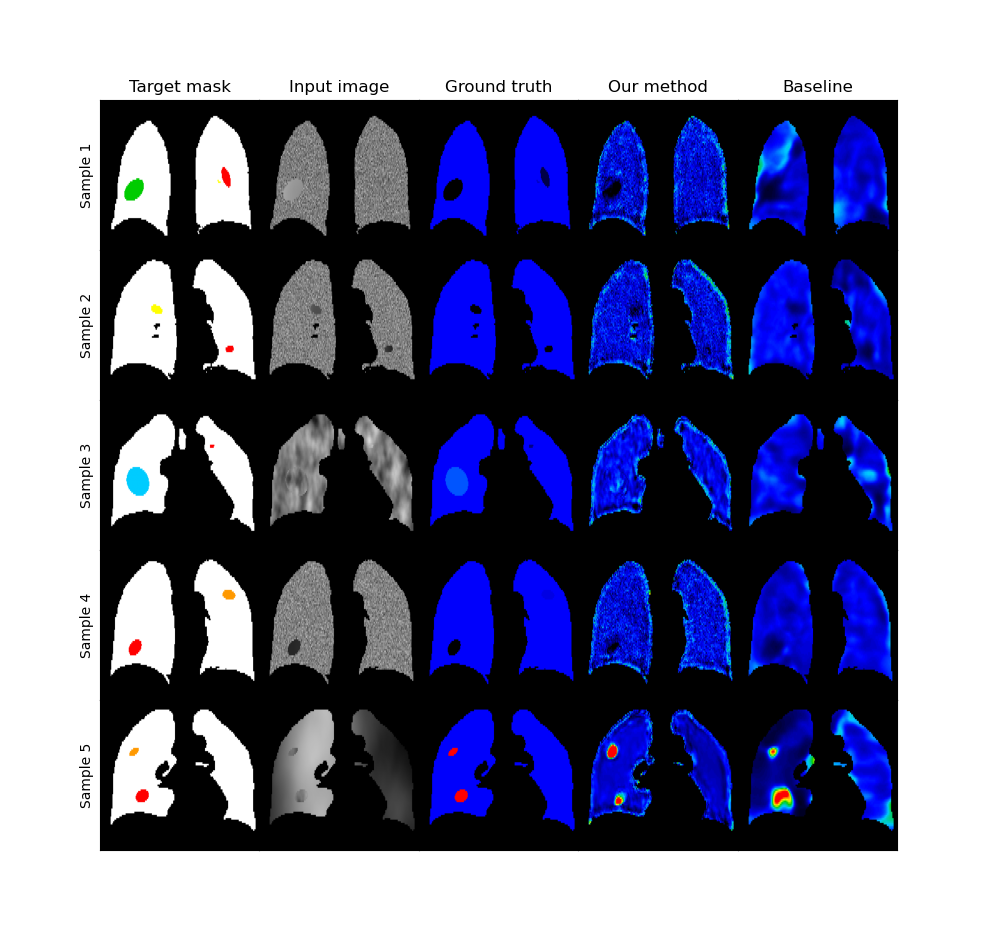

In [124]:
%autoreload

def get_y_slice(mask):
    density = mask.sum(axis=(0,2)) / mask.sum()
    return np.abs(density.cumsum() - 0.5).argmin()

model_names = [
    'Our method',
    'anat + coords',
    'Baseline'
]

model_inds = [0, 2]
columns = ['mask', 'anat', 'e_true'] + model_inds
samples = range(5)

n_rows = len(samples)
n_cols = len(columns)

fig, axes, cbar_ax = project.visual.subplot_grid(n_rows, n_cols, ax_height, ax_width, space=0, pad=1)

for row_idx, sample_idx in enumerate(samples):
    
    mask = masks[0][sample_idx]
    a_image = a_images[0][sample_idx]
    e_true = e_trues[0][sample_idx]
    
    bg_mask = (mask == 1)
    e_true_0 = (e_true * bg_mask).sum() / bg_mask.sum()
    e_true = e_true / e_true_0
    vmax = 6
    
    y_slice = get_y_slice((mask > 1)**2)
    
    for col_idx, column in enumerate(columns):
        ax = axes[row_idx,col_idx]

        if col_idx == 0:
            ax.set_ylabel(f'Sample {sample_idx+1}')
            
        if column == 'anat':
            if row_idx == 0:
                ax.set_title('Input image')
            project.visual.imshow(
                ax, (a_image)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('CT')
            )
        
        elif column == 'mask':
            if row_idx == 0:
                ax.set_title('Target mask')
            project.visual.imshow(
                ax, mask[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                **project.visual.get_color_map('regions')
            )
            masks.append(mask)
            
        elif column == 'e_true':
            if row_idx == 0:
                ax.set_title('Ground truth')
            project.visual.imshow(
                ax, (e_true)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                cmap=e_cmap, vmax=vmax, vmin=-vmax
            )
            
        else: # e_pred
            model_idx = column
            model_name = model_names[model_idx]
            job_params = param_space[model_idx]
            e_pred = e_preds[model_idx][sample_idx]

            bg_mask = (mask == 1)
            e_pred_0 = (e_pred * bg_mask).sum() / bg_mask.sum()
            e_pred = e_pred / e_pred_0
            vmax = 6
            if row_idx == 0:
                ax.set_title(model_name)
            project.visual.imshow(
                ax, (e_pred)[:,y_slice,:],
                aspect=z_res/x_res,
                interpolation_stage='rgba',
                cmap=e_cmap, vmax=vmax, vmin=-vmax
            )

        ax.set_xticks([])
        ax.set_yticks([])

for ext in ['png', 'pdf']:
    fig.savefig(f'phantom_fit2_images.{ext}', bbox_inches='tight', dpi=400)

In [199]:
import pandas as pd
metrics = pd.DataFrame(columns=['model', 'sample', 'error', 'CTE']).set_index(['model', 'sample'])
metrics

,,error,CTE
model,sample,,


In [200]:
%autoreload
for i in model_inds:
    for j in range(n_samples):
        index = (model_names[i], j)
        
        e_pred = torch.as_tensor(e_preds[i][j])
        e_true = torch.as_tensor(e_trues[i][j])
        region_mask = torch.as_tensor(masks[i][j])
        binary_mask = (region_mask > 0)

        error = project.evaluation.mean_relative_error(
            e_pred.unsqueeze(-1), e_true.unsqueeze(-1), binary_mask
        ).item() * 100
        cte = project.evaluation.contrast_transfer_efficiency(
            e_pred, e_true, region_mask
        ).item()

        metrics.loc[index, 'error'] = error
        metrics.loc[index, 'CTE'] = cte
        
metrics

error       CTE
model      sample                        
Our method 0          98.897575   0.32428
           1          98.797536  0.325323
           2          87.870619  0.644171
           3          99.071403  0.344958
           4        1714.811697  0.191275
           5          97.862987  0.377999
           6          99.088718  0.277623
           7          98.046619  0.543546
           8          98.328627   0.36269
           9          92.963437  0.327279
Baseline   0          97.056237  0.260326
           1          97.940368  0.244777
           2          60.428939  0.680969
           3          97.288069  0.305869
           4       31456.118195  0.170178
           5          92.165342  0.406728
           6          97.396151  0.230688
           7          94.169787  0.631747
           8          93.440104   0.50037
           9          76.951232  0.372319

In [206]:
help(ps.plot)

Help on function plot in module param_search.results:

plot(df, x=None, y=None, hue=None, grouped=True, block=None, block_levels=None, block_orient='h', height=3, width=3, n_cols=None, xlim={}, ylim={}, plot_func=<function pointplot at 0x147650c81ab0>, plot_kws={}, legend=True, legend_row=-1, legend_col=None, legend_kws={}, verbose=False, tight=False, gridspec_kws={})



<IPython.core.display.Javascript object>


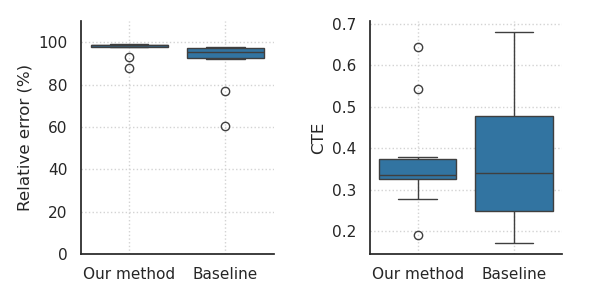

In [212]:
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
m = metrics.reset_index()
fig = ps.plot(m, x='model', y=['error', 'CTE'], n_cols=2, plot_func=sns.boxplot, height=3, width=3)
fig.axes[0].set_ylim(0, 110)
#fig.axes[1].set_ylim(0, 1)
fig.axes[0].set_xlabel(None)
fig.axes[1].set_xlabel(None)
fig.axes[0].set_ylabel('Relative error (%)')
fig.tight_layout()

In [214]:
expt_names

['2024-12-02__phantom__seed',
 '2024-12-12__phantom__fit__coords',
 '2024-12-12__phantom__fit__coords2']

In [331]:
all_metrics = []
for i in range(3):
    expt_name = expt_names[i]
    jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)
    metrics = ps.metrics(jobs, sep=',')
    metrics['expt_name'] = expt_name
    if expt_name == '2024-12-12__phantom__fit__coords':
        metrics['input_anat'] = True # CORRECTION
    all_metrics.append(metrics)
    
metrics = pd.concat(all_metrics)
metrics

,bias_range,dummy_targets,conv_channels,output_func,random_seed,job_name,job_id,partition,job_state,node_id,...,num_epochs,test_every,save_every,event,time,gpu_mem_total,gpu_mem_reserved,gpu_mem_allocated,mem_total,mem_used
0,250,False,32.0,relu,1.0,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,250,False,32.0,relu,1.0,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,250,False,32.0,relu,1.0,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,250,False,32.0,relu,1.0,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,250,False,32.0,relu,1.0,train__phantom__250__0__32__relu__1,27268618,BatComputer,PENDING,(None),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30595,0,False,NaN,exp,NaN,fit__phantom__exp__1e-05__9,27624116,BatComputer,PENDING,(None),...,1000.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30596,0,False,NaN,exp,NaN,fit__phantom__exp__1e-05__9,27624116,BatComputer,PENDING,(None),...,1000.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30597,0,False,NaN,exp,NaN,fit__phantom__exp__1e-05__9,27624116,BatComputer,PENDING,(None),...,1000.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30598,0,False,NaN,exp,NaN,fit__phantom__exp__1e-05__9,27624116,BatComputer,PENDING,(None),...,1000.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [332]:
metrics = pd.concat(all_metrics)
metrics['trainer_task'] = metrics['trainer_task'].fillna('train')
metrics['num_epochs'] = metrics['num_epochs'].fillna(200)
metrics['input_anat'] = metrics['input_anat'].fillna(True)
metrics['input_coords'] = metrics['input_coords'].fillna(False)

metrics.groupby(['expt_name', 'job_name'])[['epoch']].describe()

/var/tmp/ipykernel_22027/1398801332.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metrics['input_anat'] = metrics['input_anat'].fillna(True)
/var/tmp/ipykernel_22027/1398801332.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metrics['input_coords'] = metrics['input_coords'].fillna(False)


epoch  \
                                                                         count   
expt_name                         job_name                                       
2024-12-02__phantom__seed         train__phantom__0__0__32__relu__1    18402.0   
                                  train__phantom__0__0__32__relu__2    18402.0   
                                  train__phantom__0__0__32__relu__3    18402.0   
                                  train__phantom__0__1__32__relu__1    18402.0   
                                  train__phantom__0__1__32__relu__2    18402.0   
                                  train__phantom__0__1__32__relu__3    18402.0   
                                  train__phantom__125__0__32__relu__1  18402.0   
                                  train__phantom__125__0__32__relu__2  18402.0   
                                  train__phantom__125__0__32__relu__3  18402.0   
                                  train__phantom__125__1__32__relu__1  18402.0   
                                  train__phantom__125__1__32__relu__2  18402.0   
                                  train__phantom__125__1__32__relu__3  18402.0   
                                  train__phantom__250__0__32__relu__1  18402.0   
                                  train__phantom__250__0__32__relu__2  18402.0   
                                  train__phantom__250__0__32__relu__3  18402.0   
                                  train__phantom__250__1__32__relu__1  18402.0   
                                  train__phantom__250__1__32__relu__2  18402.0   
                                  train__phantom__250__1__32__relu__3  18402.0   
2024-12-12__phantom__fit__coords  fit__phantom__exp__1e-05__0           1020.0   
                                  fit__phantom__exp__1e-05__1           1020.0   
                                  fit__phantom__exp__1e-05__2           1020.0   
                                  fit__phantom__exp__1e-05__3           1020.0   
                                  fit__phantom__exp__1e-05__4           1020.0   
                                  fit__phantom__exp__1e-05__5           1020.0   
                                  fit__phantom__exp__1e-05__6           1020.0   
                                  fit__phantom__exp__1e-05__7           1020.0   
                                  fit__phantom__exp__1e-05__8           1020.0   
                                  fit__phantom__exp__1e-05__9           1020.0   
                                  fit__phantom__relu__1e-05__0          1020.0   
                                  fit__phantom__relu__1e-05__1          1020.0   
                                  fit__phantom__relu__1e-05__2          1020.0   
                                  fit__phantom__relu__1e-05__3          1020.0   
                                  fit__phantom__relu__1e-05__4          1020.0   
                                  fit__phantom__relu__1e-05__5          1020.0   
                                  fit__phantom__relu__1e-05__6          1020.0   
                                  fit__phantom__relu__1e-05__7          1020.0   
                                  fit__phantom__relu__1e-05__8          1020.0   
                                  fit__phantom__relu__1e-05__9          1020.0   
                                  fit__phantom__softplus__1e-05__0      1020.0   
                                  fit__phantom__softplus__1e-05__1      1020.0   
                                  fit__phantom__softplus__1e-05__2      1020.0   
                                  fit__phantom__softplus__1e-05__3      1020.0   
                                  fit__phantom__softplus__1e-05__4      1020.0   
                                  fit__phantom__softplus__1e-05__5      1020.0   
                                  fit__phantom__softplus__1e-05__6      1020.0   
                                  fit__phantom__softplus__1e-05__7      1020.0   
                                  fit__phantom__softplu

In [333]:
metrics.groupby(
    ['expt_name', 'trainer_task', 'bias_range', 'dummy_targets', 'input_anat', 'input_coords', 'output_func']
)[['job_name']].nunique()

job_name
expt_name                         trainer_task bias_range dummy_targets input_anat input_coords output_func          
2024-12-02__phantom__seed         train        0          False         True       False        relu                3
                                                          True          True       False        relu                3
                                               125        False         True       False        relu                3
                                                          True          True       False        relu                3
                                               250        False         True       False        relu                3
                                                          True          True       False        relu                3
2024-12-12__phantom__fit__coords  fit          0          False         True       True         exp                10
                                                                                                relu               10
                                                                                                softplus           10
2024-12-12__phantom__fit__coords2 fit          0          False         False      True         exp                10
                                                                                                relu               10
                                                                                                softplus           10

In [334]:
m = metrics.copy()
m = m[
    ((m.trainer_task == 'train') & (m.bias_range == 0) & (m.dummy_targets == False)) |
    ((m.trainer_task == 'fit') & (m.input_anat == False) & (m.output_func == 'softplus'))
]
m.groupby(
    ['expt_name', 'trainer_task', 'bias_range', 'dummy_targets', 'input_anat', 'input_coords', 'output_func']
)[['job_name']].nunique()

,,,,,,,job_name
expt_name,trainer_task,bias_range,dummy_targets,input_anat,input_coords,output_func,
2024-12-02__phantom__seed,train,0,False,True,False,relu,3
2024-12-12__phantom__fit__coords2,fit,0,False,False,True,softplus,10


In [361]:
test_set = {f'phantom{i}' for i in range(10)}

m = m[
    m.example.isin(test_set) & (m.epoch/m.num_epochs > 0.5)
]
m.groupby(['expt_name', 'trainer_task', 'phase', 'example', 'rep'])[['epoch']].describe()

epoch  \
                                                                     count   
expt_name                         trainer_task phase example  rep            
2024-12-02__phantom__seed         train        test  phantom0 dofs    29.0   
                                                              image   29.0   
                                                     phantom1 dofs    30.0   
                                                              image   30.0   
                                                     phantom2 dofs    30.0   
                                                              image   30.0   
                                                     phantom3 dofs    29.0   
                                                              image   29.0   
                                                     phantom4 dofs    30.0   
                                                              image   30.0   
                                                     phantom5 dofs    30.0   
                                                              image   30.0   
                                                     phantom6 dofs    30.0   
                                                              image   30.0   
                                                     phantom7 dofs    30.0   
                                                              image   30.0   
                                                     phantom8 dofs    31.0   
                                                              image   31.0   
                                                     phantom9 dofs    31.0   
                                                              image   31.0   
2024-12-12__phantom__fit__coords2 fit          test  phantom0 image    5.0   
                                                     phantom1 image    5.0   
                                                     phantom2 image    5.0   
                                                     phantom3 image    5.0   
                                                     phantom4 image    5.0   
                                                     phantom5 image    5.0   
                                                     phantom6 image    5.0   
                                                     phantom7 image    5.0   
                                                     phantom8 image    5.0   
                                                     phantom9 image    5.0   
                                               train phantom0 dofs   500.0   
                                                     phantom1 dofs   500.0   
                                                     phantom2 dofs   500.0   
                                                     phantom3 dofs   500.0   
                                                     phantom4 dofs   500.0   
                                                     phantom5 dofs   500.0   
                                                     phantom6 dofs   500.0   
                                                     phantom7 dofs   500.0   
                                                     phantom8 dofs   500.0   
                                                     phantom9 dofs   500.0   

                                                                                 \
                                                                           mean   
expt_name                         trainer_task phase example  rep                 
2024-12-02__phantom__seed         train        test  phantom0 dofs   151.172414   
                                                              image  151.172414   
                                                     phantom1 dofs   153.733333   
                                                              image  153.733333   
                                                     phantom2 dofs   149.333333   
                                                  

<IPython.core.display.Javascript object>


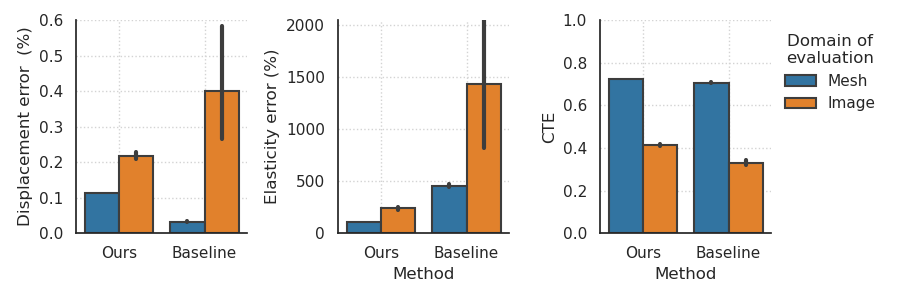

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/results.py:329: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '#3d3d3d'}` instead.

  ax = sns.barplot(errwidth=lw * 2, errcolor=gray, *args, **kwargs)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/results.py:329: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 3.0}` instead.

  ax = sns.barplot(errwidth=lw * 2, errcolor=gray, *args, **kwargs)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_search/param_search/results.py:329: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '#3d3d3d'}` instead.

  ax = sns.barplot(errwidth=lw * 2, errcolor=gray, *args, **kwargs)
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../param_s

In [378]:
m = metrics.copy()

u_error_col = 'Displacement error  (%)'
e_error_col = 'Elasticity error (%)'
cte_col = 'CTE'

m[u_error_col] = m['u_error'] * 100
m[e_error_col] = m['e_error'] * 100

method_col = 'Method'
m[method_col] = m['trainer_task'].map({'train':'Ours', 'fit':'Baseline'}.__getitem__)

rep_col = 'Domain of\nevaluation'
m[rep_col] = m['rep'].fillna('nan').map({'image':'Image', 'dofs':'Mesh', 'nan': np.nan}.__getitem__)

fig = ps.plot(
    m,
    x=[method_col],
    y=[u_error_col, e_error_col, cte_col],
    hue=rep_col,
    n_cols=4,
    height=3,
    tight=True,
    legend_col=2,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylim(0, 0.6)
fig.axes[0].set_ylabel(u_error_col)
fig.axes[0].set_xlabel(None)

fig.axes[1].set_ylim(0, 2050)
fig.axes[1].set_ylabel(e_error_col)
fig.axes[0].set_xlabel(None)

fig.axes[2].set_ylim(0, 1)
fig.axes[2].set_ylabel(cte_col)
fig.axes[0].set_xlabel(None)

for ext in ['pdf', 'png']:
    fig.savefig(f'phantom_lung_results.{ext}', bbox_inches='tight', dpi=200)

job_name
expt_name                         bias_range dummy_targets output_func          
2024-12-02__phantom__seed         0          False         relu                3
                                             True          relu                3
                                  125        False         relu                3
                                             True          relu                3
                                  250        False         relu                3
                                             True          relu                3
2024-12-12__phantom__fit__coords  0          False         exp                10
                                                           relu               10
                                                           softplus           10
2024-12-12__phantom__fit__coords2 0          False         exp                10
                                                           relu               10
                                                           softplus           10